In [2]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

# <------ Example Usage ------>

img = scipy.misc.face()

In [14]:
# <------ Algorithm 1 ------>

# This is the semi-implicit gradient descent algorithm proposed in Section 3 of [1].
# Parameters:
#   img: The grayscale image to process. Type: (m,n)-shaped ndarray
#   lam: Lambda value. Type: float
#   max_iter: The maximum number of iterations. Type: int
#   epsilon: Coefficient for the stopping criteria. If you set this to 0, the number of 
#   iterations will always be max_iter. Type: float
#   log: Whether to log the initial and final TV of the image and the number
#        of total iterations. Type: bool
def tv_denoise_grayscale(img, lam, max_iter=50, epsilon=1e-3, log=False):
    (m,n) = img.shape
    N = np.sqrt(m*n) # Geometric mean
    
    if log:
        print("Initial TV =", tv(img))
    
    # Initialization
    u = np.zeros((m,n))
    u_prev = np.zeros_like(u)
    div_p = np.zeros_like(u)
    grad_u = np.zeros((2,m,n))
    p = np.zeros_like(grad_u)

    tau = 0.248 # See remark in Section 3
    
    # Iteration
    for i in range(max_iter):
        div_p = div(p)
        u = img - lam * div_p
        grad_u = grad(u)
        grad_u_norm = np.linalg.norm(grad_u)
        p -= (tau/lam) * grad_u
        p /= 1 + (tau/lam) * grad_u_norm
        
        if np.linalg.norm(u_prev - u) < N*epsilon:
            if log:
                print("Converged at iteration", i)
            break
        u_prev = u
        
    if log:
        print("Final TV =", tv(u))
        
    return u

# This is just another version of tv_denoise_grayscale() that processes RGB images
# instead. The channels are processed independently and then combined.
def tv_denoise_rgb(img, lam, max_iter=50, epsilon=1e-3, log=False):
    (m,n) = img.shape[:2]
    red = img[:,:,0]
    green = img[:,:,1]
    blue = img[:,:,2]
    if log:
        print("<--- Red channel begin --->")
    denoised_red = tv_denoise_grayscale(red, lam, max_iter, epsilon, log)
    if log:
        print("<--- Red channel end --->")
        print("<--- Green channel begin --->")
    denoised_green = tv_denoise_grayscale(green, lam, max_iter, epsilon, log)
    if log:
        print("<--- Green channel end --->")
        print("<--- Blue channel begin --->")
    denoised_blue = tv_denoise_grayscale(blue, lam, max_iter, epsilon, log)
    if log:
        print("<--- Blue channel end --->")
    
    o = np.zeros((m,n,3))
    for i in range(m):
        for j in range(n):
            o[i,j,0] = denoised_red[i,j]
            o[i,j,1] = denoised_green[i,j]
            o[i,j,2] = denoised_blue[i,j]
            
    return o

# <------ Algorithm 2 ------>

# This is the algorithm proposed in Section 4 of [1]. It converges
# faster than Algorithm 1.
# Parameters:
#   img: The grayscale image to process. Type: (m,n)-shaped ndarray
#   sigma: The estimated standard deviation of the Gaussian noise. Type: float
#   max_iter: The maximum number of iterations. Type: int
#   epsilon: Coefficient for the stopping criteria. If you set this to 0, the number of 
#   iterations will always be max_iter. Type: float
#   log: Whether to log the initial and final TV of the image and the number
#        of total iterations. Type: bool
def tv_improved_denoise_grayscale(img, sigma, max_iter=50, epsilon=1e-3, log=False):
    (m,n) = img.shape
    N = np.sqrt(m*n) # Geometric mean
    
    if log:
        print("Initial TV =", tv(img))
    
    # Initialization
    lam = 1.0 # lam > 0 is arbitrary
    v = np.zeros((m,n))
    f = 1.0
    out = np.zeros_like(v)
    out_prev = np.zeros_like(v)
    
    max_inner_iter = 10
    u = np.zeros_like(v)
    grad_u = np.zeros((2,m,n))
    p = np.zeros_like(grad_u)
    div_p = np.zeros_like(v)
    tau = 0.248
    
    # Iteration
    for i in range(max_iter):
        
        lam *= N * sigma / f
        
        # Calculate projection with Algorithm 1
        for j in range(max_inner_iter):
            div_p = div(p)
            u = img - lam * div_p
            grad_u = grad(u)
            grad_u_norm = np.linalg.norm(grad_u)
            p -= (tau/lam) * grad_u
            p /= 1 + (tau/lam) * grad_u_norm
            
        div_p_norm = np.linalg.norm(div_p)
        # See "In practice, we have observed that..." at page 93
        lam = N*sigma / div_p_norm 
        v = lam * div_p
        
        f = np.linalg.norm(v)
        out = img - v
        
        if np.linalg.norm(out_prev - out) < m*n*epsilon:
            if log:
                print("Converged at iteration", i)
            break
        out_prev = out
        
    if log:
        print("Final TV =", tv(out))
        
    return out

# This is just another version of tv_improved_denoise_grayscale() that processes RGB images
# instead. The channels are processed independently and then combined.
def tv_improved_denoise_rgb(img, sigma, max_iter=50, epsilon=1e-3, log=False):
    (m,n) = img.shape[:2]
    red = img[:,:,0]
    green = img[:,:,1]
    blue = img[:,:,2]
    if log:
        print("<--- Red channel begin --->")
    denoised_red = tv_improved_denoise_grayscale(red, sigma, max_iter, epsilon, log)
    if log:
        print("<--- Red channel end --->")
        print("<--- Green channel begin --->")
    denoised_green = tv_improved_denoise_grayscale(green, sigma, max_iter, epsilon, log)
    if log:
        print("<--- Green channel end --->")
        print("<--- Blue channel begin --->")
    denoised_blue = tv_improved_denoise_grayscale(blue, sigma, max_iter, epsilon, log)
    if log:
        print("<--- Blue channel end --->")
    
    o = np.zeros([m,n,3])
    for i in range(m):
        for j in range(n):
            o[i,j,0] = denoised_red[i,j]
            o[i,j,1] = denoised_green[i,j]
            o[i,j,2] = denoised_blue[i,j]
            
    return o

# <------ Operators ------>

# Discrete gradient
# Parameters:
#   img: (m,n)-shaped ndarray
# Return value: (2,m,n)-shaped ndarray
def grad(img):
    (m,n) = img.shape
    
    # Pad
    padded_x = np.zeros([m+1,n])
    padded_x[:m] = img
    padded_x[m] = img[-1]
    padded_y = np.zeros([m,n+1])
    padded_y[:,:n] = img
    padded_y[:,n] = img[:,-1]
    
    # Diff
    grad_x = np.diff(padded_x, axis=0)
    grad_y = np.diff(padded_y, axis=1)
    
    o = np.array([grad_x, grad_y])           
    return o

# Discrete divergence
# Parameter:
#   g: (2,m,n)-shaped ndarray
# Return value: (m,n)-shaped ndarray
def div(g):
    (m,n) = g.shape[-2:]
    
    # Pad
    g_x = np.zeros([m+1,n])
    g_x[1:m] = g[0,:m-1,:]
    g_y = np.zeros([m,n+1])
    g_y[:,1:n] = g[1,:,:n-1]
    
    # Diff
    div_from_x = np.diff(g_x, axis=0)
    div_from_y = np.diff(g_y, axis=1)
    
    o = div_from_x + div_from_y     
    return o

# Discrete total variation
# Parameters:
#   x: (m,n)-shaped ndarray
# Return value: float
def tv(x):
    (m,n) = x.shape
    grad_x = grad(x)
    
    sum = 0.0
    for i in range(m):
        for j in range(n):
            sum += np.linalg.norm(grad_x[:,i,j])
            
    return sum




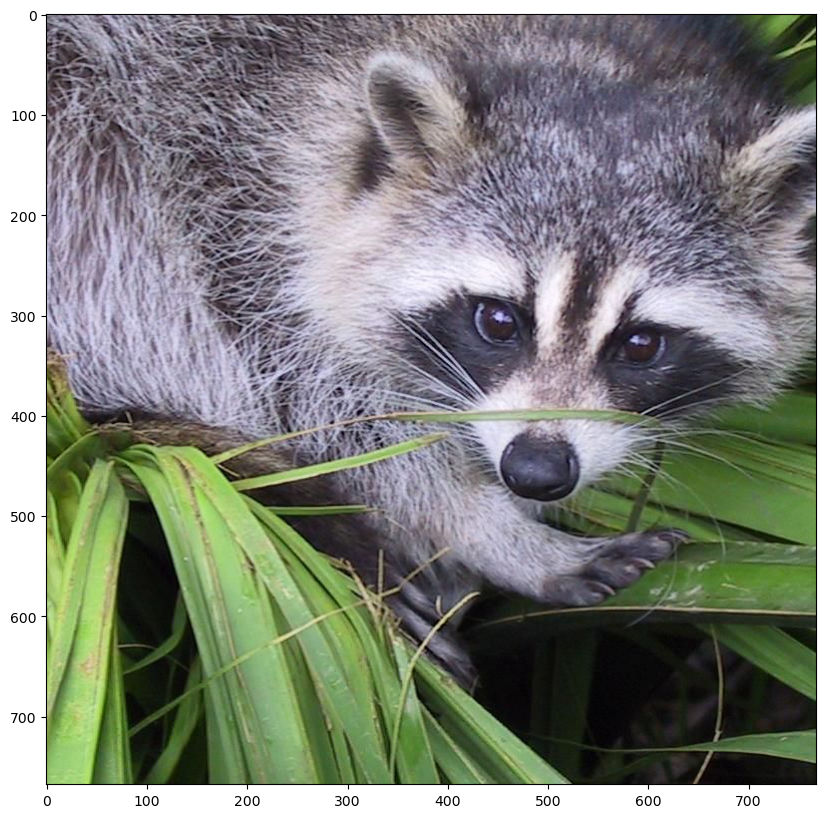

In [15]:
(h,w) = img.shape[:2]
if img.ndim == 2:
    img = img[:,(w-h)//2:(w+h)//2] 
else:
    img = img[:,(w-h)//2:(w+h)//2,:]

# Plot image
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.show()


/var/folders/7b/59gc4b9959n365ldfscy_8840000gn/T/ipykernel_32443/2113998707.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  noisy_img = img.astype(np.float)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


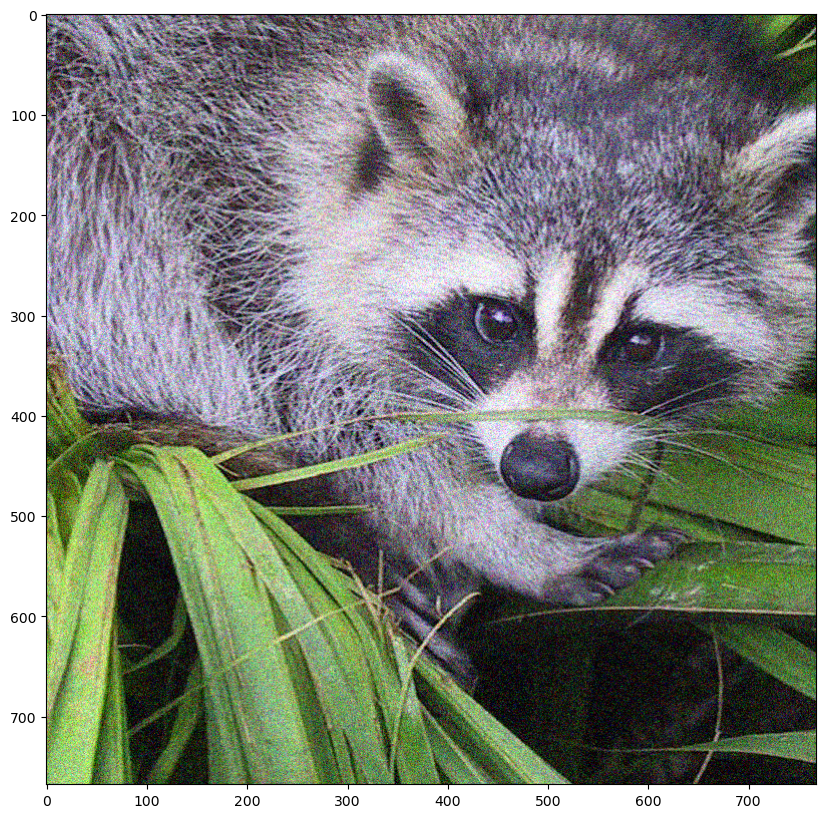

In [16]:

# Generate and plot noisy image
noisy_img = img.astype(np.float)
sigma = 30 # Standard deviation of noise
noisy_img += sigma * np.random.randn(*img.shape) # components of randn() are unit Gaussians
plt.figure(figsize=(10,10))
plt.imshow(noisy_img.astype(int), cmap='gray')
plt.show()


<--- Red channel begin --->
Initial TV = 32377088.304559223
Converged at iteration 17
Final TV = 3958431.3264883086
<--- Red channel end --->
<--- Green channel begin --->
Initial TV = 32393252.397147484
Converged at iteration 17
Final TV = 4041164.3409514623
<--- Green channel end --->
<--- Blue channel begin --->
Initial TV = 32347899.935983583
Converged at iteration 17
Final TV = 3924556.69777512
<--- Blue channel end --->


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


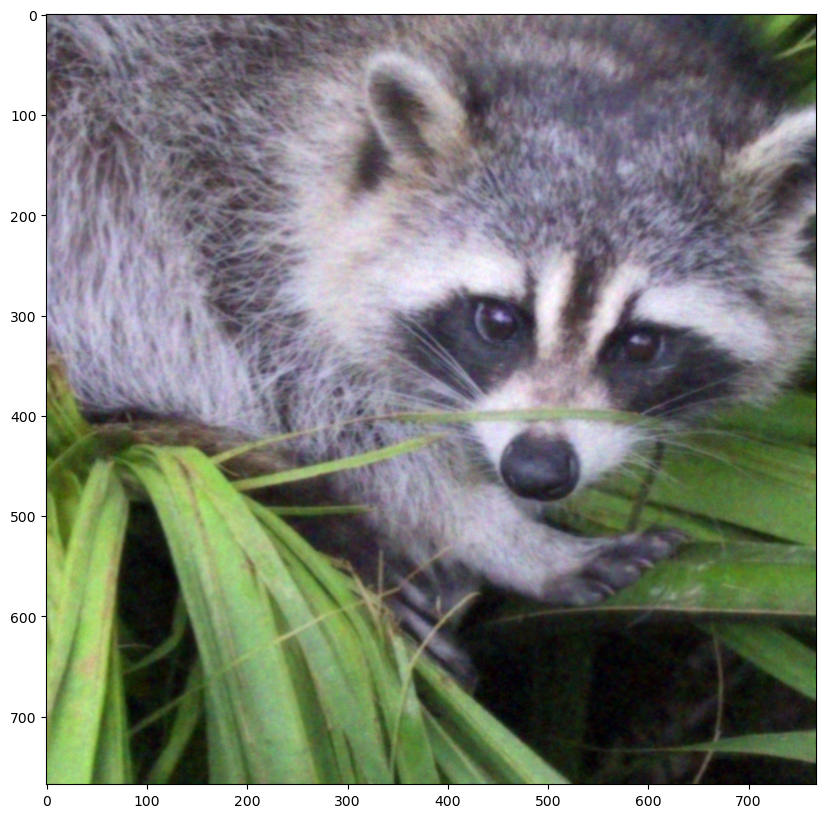

In [17]:

# Generate and plot denoised image
denoised_img = tv_improved_denoise_rgb(noisy_img, sigma=30, max_iter=50, epsilon=1e-5, log=True)
# denoised_img = tv_improved_denoise(noisy_img, sigma=30, max_iter=50, epsilon=1e-5, log=True) # For grayscale
plt.figure(figsize = (10,10))
plt.imshow(denoised_img.astype(int), cmap='gray')
plt.show()